In [1]:
%load_ext autoreload
%autoreload 2

## 1. Read in data, pre-process and create the model

In [2]:
# read in pickled cifar-10 data
import pickle
import numpy as np
import matplotlib.pyplot as plt

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# read in the data and convert the pixel values to float32
train = unpickle('data/cifar10/data_batch_1')
val = unpickle('data/cifar10/data_batch_2')
test = unpickle('data/cifar10/test_batch')
x_train, y_train = train[b"data"].astype(np.float32), np.array(train[b"labels"])
x_val, y_val = val[b"data"].astype(np.float32), np.array(val[b"labels"])
x_test, y_test = test[b"data"].astype(np.float32), np.array(test[b"labels"])


# drop 70% of val for ease of use
ind = int(len(x_val)*0.3)
ind = np.random.permutation(len(x_val))[:ind] # there may otherwise be some structure in the data
x_val, y_val = x_val[ind], y_val[ind]

FileNotFoundError: [Errno 2] No such file or directory: 'data/cifar10/data_batch_1'

In [3]:
# normalize the input data with the mean and std of the training data
mean, std = x_train.mean(), x_train.std()
x_train, x_val, x_test = (x_train - mean) / std, (x_val - mean) / std, (x_test - mean) / std

# one-hot encode the labels
y_train, y_val, y_test = np.eye(10)[y_train], np.eye(10)[y_val], np.eye(10)[y_test]

In [3]:
import math
from milligrad import Tensor

class MLP: 
    def __init__(self):
        self.w1 = Tensor.randn(3072, 50) / math.sqrt(3072) # Xavier/Glorot initialization (sometimes done with d_in+d_out)
        self.b1 = Tensor.zeros(50)
        self.w2 = Tensor.randn(50, 10) / math.sqrt(50)
        self.b2 = Tensor.zeros(10)
        
    def __call__(self, x:Tensor) -> Tensor:
        x = (x @ self.w1 + self.b1).relu()
        return x @ self.w2 + self.b2 # for numerical stability, we don't use softmax here but do log_softmax in the loss function
    
    def parameters(self)->list[Tensor]: return [self.w1, self.b1, self.w2, self.b2]
    
test = MLP()
test.w1.mean(), test.w1.std().mean(), 1 / math.sqrt(3072)
# mean is close to zero and std is close to 1/sqrt(3072) as expected 

(Tensor(-5.20511847e-05, grad_fn=/),
 Tensor(0.01775822, grad_fn=/),
 0.018042195912175808)

## 2. Double checking the network forward / backward passes
Since my solution differs significantly from what is provided in the starter code, I will double check the forward and backward passes by comparing to pytorch's implementation.

In [4]:
import torch

LAMBDA = 1e-2
x_np = np.random.randn(64, 3072)
y_np = np.eye(10)[np.random.randint(0, 10, 64)]

w1_np, b1_np = np.random.randn(3072, 50) / math.sqrt(3072), np.zeros(50)
w2_np, b2_np = np.random.randn(50, 10) / math.sqrt(50), np.zeros(10)

x_milli, y_milli = Tensor(x_np), Tensor(y_np)
w1_milli, b1_milli = Tensor(w1_np), Tensor(b1_np)
w2_milli, b2_milli = Tensor(w2_np), Tensor(b2_np)

x_torch, y_torch = torch.tensor(x_np, requires_grad=True), torch.tensor(y_np)
w1_torch, b1_torch = torch.tensor(w1_np, requires_grad=True), torch.tensor(b1_np, requires_grad=True)
w2_torch, b2_torch = torch.tensor(w2_np, requires_grad=True), torch.tensor(b2_np, requires_grad=True)

output_milli = (x_milli @ w1_milli + b1_milli).relu() @ w2_milli + b2_milli
output_torch = (x_torch @ w1_torch + b1_torch).relu() @ w2_torch + b2_torch
np.testing.assert_allclose(output_milli.data, output_torch.data.numpy(), err_msg="forward pass mismatch")

loss_milli = -(y_milli * output_milli.log_softmax()).sum(axis=1).mean()
loss_torch = -(y_torch * output_torch.log_softmax(dim=1)).sum(axis=1).mean()
np.testing.assert_allclose(loss_milli.data, loss_torch.data.numpy(), err_msg="loss mismatch")

cost_milli = LAMBDA * ((w1_milli ** 2).sum() + (w2_milli ** 2).sum())
cost_torch = LAMBDA * ((w1_torch ** 2).sum() + (w2_torch ** 2).sum())
np.testing.assert_allclose(cost_milli.data, cost_torch.data.numpy(), err_msg="cost mismatch")

(loss_milli + cost_milli).backward()
(loss_torch + cost_torch).backward()
np.testing.assert_allclose(w1_milli.grad, w1_torch.grad.data.numpy(), err_msg="w1 grad mismatch")
np.testing.assert_allclose(b1_milli.grad, b1_torch.grad.data.numpy(), err_msg="b1 grad mismatch")
np.testing.assert_allclose(w2_milli.grad, w2_torch.grad.data.numpy(), err_msg="w2 grad mismatch")
np.testing.assert_allclose(b2_milli.grad, b2_torch.grad.data.numpy(), err_msg="b2 grad mismatch")

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0
w1 grad mismatch
Mismatched elements: 34391 / 153600 (22.4%)
Max absolute difference: 6.87933077e-09
Max relative difference: 0.00315813
 x: array([[ 0.000154,  0.022313,  0.010678, ...,  0.005694,  0.014027,
        -0.01493 ],
       [ 0.032396,  0.018643,  0.011172, ..., -0.005201, -0.012001,...
 y: array([[ 0.000154,  0.022313,  0.010678, ...,  0.005694,  0.014027,
        -0.01493 ],
       [ 0.032396,  0.018643,  0.011172, ..., -0.005201, -0.012001,...

### So we see that the forward and backward passes are consistent with pytorch's implementation.
In fact, I knew that this would be the case since I robustly check the correctness of my code via unit tests by comparing to pytorch's implementation. Everything from \_\_add\_\_ to log_softmax is tested.

### Now for the sanity check

In [5]:
def accuracy(y, y_hat):
    return np.mean(y.argmax(axis=1) == y_hat.argmax(axis=1))

In [6]:
class GD:
    def __init__(self, params:list[Tensor], lr:float=0.01):
        self.params = params
        self.lr = lr

    def step(self):
        for p in self.params:
            p.data -= self.lr * p.grad  
            
    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)
            
class CyclicScheduler:
    def __init__(self, opt, lr_start: float, lr_end: float, stepsize: int):
        self.opt = opt
        self.lr_start = lr_start
        self.lr_end = lr_end
        self.stepsize = stepsize
        
        self.t = 0  # Current step within the cycle

    def step(self):
        cycle = self.t // (2 * self.stepsize)
        x = abs(self.t / self.stepsize - 2 * cycle - 1)
        lr = self.lr_start + (self.lr_end -  self.lr_start) * max(0, (1 - x))
        self.opt.lr = lr
        self.t += 1

        if self.t >= 2 * self.stepsize:
            self.t = 0

In [7]:
from tqdm import tqdm

EPOCHS = 40
BATCH_SIZE = 100
ETA_MAX = 1e-1
ETA_MIN = 1e-5
LAMBDA = 1e-2

def train(model, optim, sched, x_train, y_train, x_val, y_val):
    lrs = []
    train_losses_epoch, train_costs_epoch = [], []
    val_losses_epoch, val_costs_epoch = [], []
    train_accs_epoch, val_accs_epoch = [], []
    for _ in tqdm(range(EPOCHS)):
        train_losses, train_costs, train_accs = [], [], []
        permutation = np.random.permutation(len(x_train))
        for i in range(len(x_train) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_train[idxs])
            y = Tensor(y_train[idxs])
            y_hat = model(x)
            # cross-entropy loss with L2 regularization cost
            # sum over classes, then mean over batch for cross-entropy
            loss = -(y * y_hat.log_softmax()).sum(axis=-1).mean()
            # here y acts as a selector (due to ohe) so GD minimizes -log(y_hat_correct) i.e. maximizing the likelihood
            cost = LAMBDA * ((model.w1 ** 2).sum() + (model.w2 ** 2).sum())
            
            optim.zero_grad()
            (loss + cost).backward()
            optim.step()
            sched.step()
            
            lrs.append(optim.lr)
            train_losses.append(loss.data)
            train_costs.append(cost.data)
            train_accs.append(accuracy(y.data, y_hat.data))
        
        val_losses, val_accs = [], []
        permutation = np.random.permutation(len(x_val))
        for i in range(len(x_val) // BATCH_SIZE):
            idxs = permutation[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            x = Tensor(x_val[idxs])
            y = Tensor(y_val[idxs])
            y_hat_val = model(x)
            val_loss = -(y * y_hat_val.log_softmax()).sum(axis=-1).mean()
            
            val_losses.append(val_loss.data)
            val_accs.append(accuracy(y.data, y_hat_val.data))
        
        train_losses_epoch.append(np.mean(train_losses))
        train_costs_epoch.append(np.mean(train_costs))
        train_accs_epoch.append(np.mean(train_accs))
        
        val_losses_epoch.append(np.mean(val_losses))
        val_costs_epoch.append(cost.data) # L2 doesnt change in validation so we just copy the last value
        val_accs_epoch.append(np.mean(val_accs))
        
    return (
        (train_losses_epoch, train_costs_epoch, train_accs_epoch),
        (val_losses_epoch, val_costs_epoch, val_accs_epoch),
        lrs
    )

In [8]:
np.random.seed(400)

EPOCHS = 100
ETA_MAX = 1e-2 # just dummy values to do sanity check
ETA_MIN = 1e-2
LAMBDA = 0.0

model = MLP()
optim = GD(model.parameters(), lr=ETA_MAX)
sched = CyclicScheduler(optim, ETA_MIN, ETA_MAX, stepsize=10000)

(train_losses_epoch, train_costs_epoch, train_accs_epoch), (val_losses_epoch, val_costs_epoch, val_accs_epoch), lrs = \
    train(model, optim, sched, x_train[:100], y_train[:100], x_val[:100], y_val[:100])

NameError: name 'x_train' is not defined

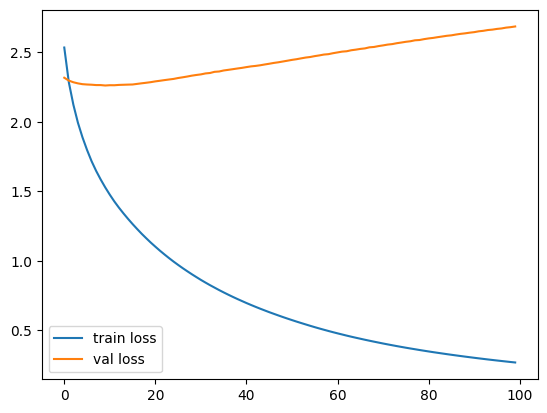

In [48]:
plt.plot(train_losses_epoch, label="train loss")
plt.plot(val_losses_epoch, label="val loss")
plt.legend()
plt.show()

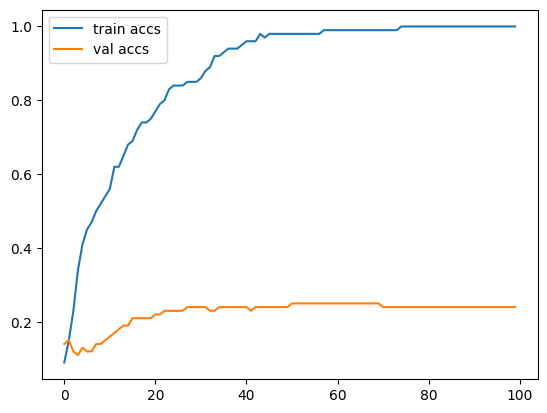

In [49]:
plt.plot(train_accs_epoch, label="train accs")
plt.plot(val_accs_epoch, label="val accs")
plt.legend()
plt.show()

### So we can overfit the data easily

## 3. Training with Cyclical Learning Rates

In [55]:
BATCHES_PER_EPOCH

450

In [56]:
np.random.seed(400)
NS = 500
BATCH_SIZE = 100
BATCHES_PER_EPOCH = len(x_train) // BATCH_SIZE
EPOCHS = 1 * math.ceil((2 * NS) / BATCHES_PER_EPOCH) # a bit more than 1 cycle
ETA_MAX = 1e-1
ETA_MIN = 1e-5
LAMBDA = 1e-2


model = MLP()
optim = GD(model.parameters(), lr=ETA_MIN)
sched = CyclicScheduler(optim, lr_start=ETA_MIN, lr_end=ETA_MAX, stepsize=NS)

(train_losses, train_costs, train_accs), (val_losses, val_costs, val_accs), lrs = train(model, optim, sched, x_train, y_train, x_val, y_val)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:16<00:00,  5.57s/it]


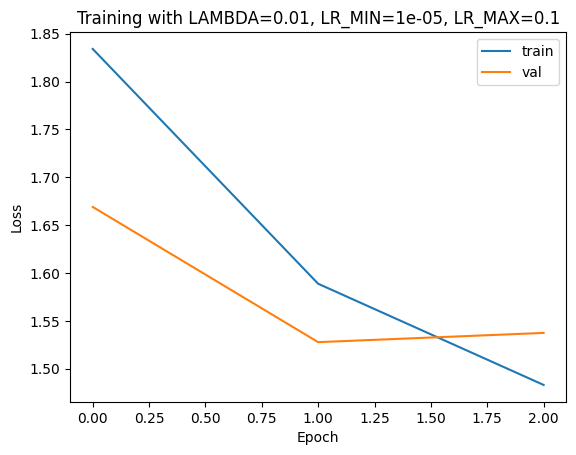

In [57]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

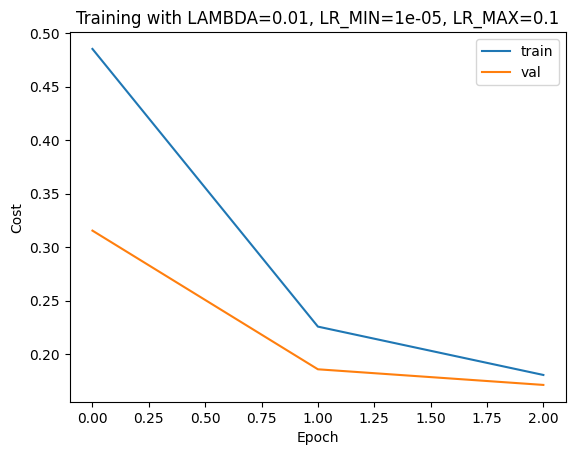

In [58]:
plt.plot(train_costs, label="train")
plt.plot(val_costs, label="val")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

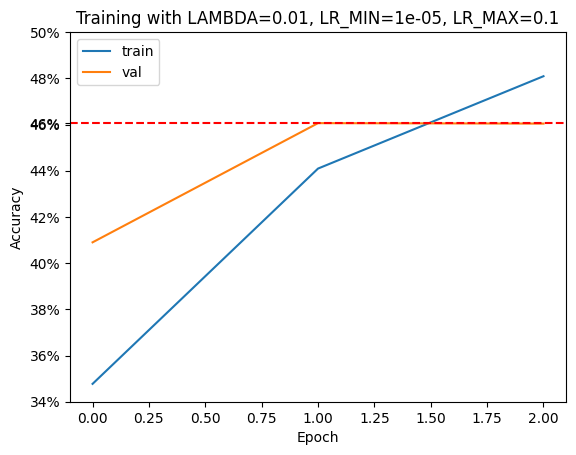

In [59]:
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")

plt.axhline(max(val_accs), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(val_accs)])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

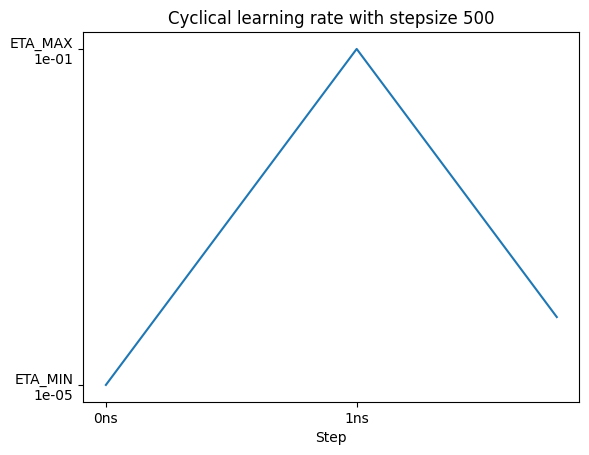

In [54]:
plt.plot(lrs)
plt.xlabel("Step")
plt.title(f"Cyclical learning rate with stepsize {NS}")

steps = len(lrs) // NS + 1
plt.xticks([i*NS for i in range(steps)], [f"{i}ns" for i in range(steps)])
plt.yticks([ETA_MIN, ETA_MAX], [f"ETA_MIN\n{ETA_MIN:0.0e}", f"ETA_MAX\n{ETA_MAX:0.0e}"])

plt.show()

In [18]:
accuracy(y_test, model(Tensor(x_test)).data)
# achieves 45.87% accuracy on the test set

0.4587

## 4. Training network for real


Read all data except test_batch, and randomly split it into N-5000 training samples and 5000 validation samples.

In [60]:
x = []
y = []
for i in range(1, 6):
    data = unpickle(f'data/cifar10/data_batch_{i}')
    x.append(data[b"data"].astype(np.float32))
    y.append(np.array(data[b"labels"]))
    
x = np.concatenate(x)
y = np.concatenate(y)
n_train = len(x) - 5000
idx_shuffle = np.random.permutation(len(x))
x_train, x_val = x[idx_shuffle][:n_train], x[idx_shuffle][n_train:]
y_train, y_val = y[idx_shuffle][:n_train], y[idx_shuffle][n_train:]

# normalize the input data with the mean and std of the training data
mean, std = x_train.mean(), x_train.std()
x_train, x_val = (x_train - mean) / std, (x_val - mean) / std

# one-hot encode the labels
y_train, y_val = np.eye(10)[y_train], np.eye(10)[y_val]

x_train.shape, x_val.shape
# ((45000, 3072), (5000, 3072))

((45000, 3072), (5000, 3072))

In [61]:
np.random.seed(400)
BATCHES_PER_EPOCH = len(x_train) // BATCH_SIZE
NS = 800
EPOCHS = 3 * math.ceil((2 * NS) / BATCHES_PER_EPOCH) # a bit more than 3 cycles
BATCH_SIZE = 100
ETA_MAX = 1e-1
ETA_MIN = 1e-5
LAMBDA = 1e-2

model = MLP()
optim = GD(model.parameters(), lr=ETA_MIN)
sched = CyclicScheduler(optim, lr_start=ETA_MIN, lr_end=ETA_MAX, stepsize=NS)

(train_losses, train_costs, train_accs), (val_losses, val_costs, val_accs), lrs = train(model, optim, sched, x_train, y_train, x_val, y_val)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:59<00:00,  5.00s/it]


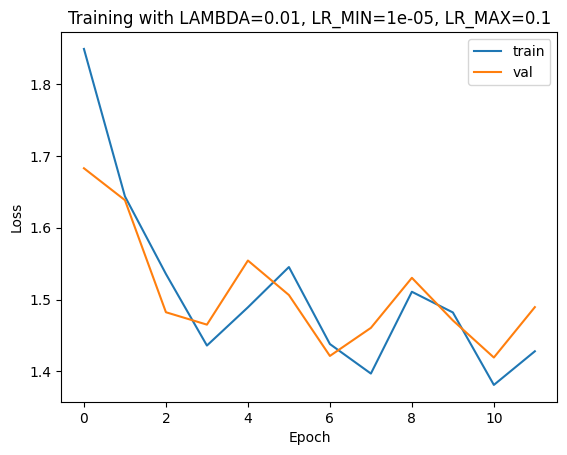

In [62]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

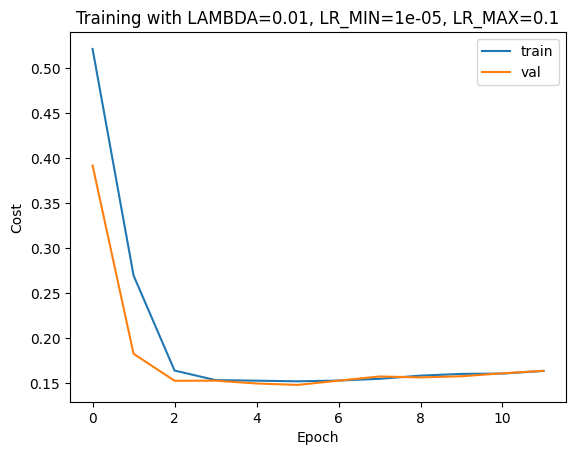

In [63]:
plt.plot(train_costs, label="train")
plt.plot(val_costs, label="val")
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

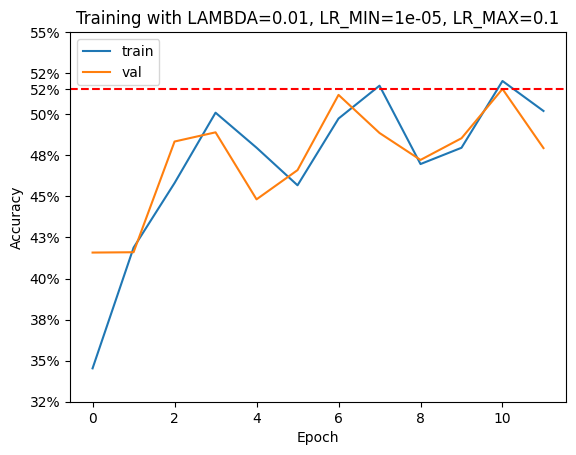

In [64]:
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")

plt.axhline(max(val_accs), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(val_accs)])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

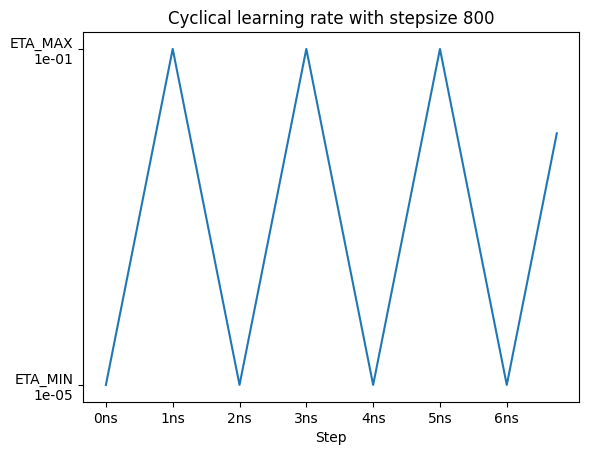

In [65]:
plt.plot(lrs)
plt.xlabel("Step")
plt.title(f"Cyclical learning rate with stepsize {NS}")

steps = len(lrs) // NS + 1
plt.xticks([i*NS for i in range(steps)], [f"{i}ns" for i in range(steps)])
plt.yticks([ETA_MIN, ETA_MAX], [f"ETA_MIN\n{ETA_MIN:0.0e}", f"ETA_MAX\n{ETA_MAX:0.0e}"])

plt.show()

In [67]:
accuracy(y_test, model(Tensor(x_test)).data)
# achieves 47.12% accuracy on the test set

0.4712

In [68]:
BATCHES_PER_EPOCH = len(x_train) // BATCH_SIZE
NS = 2 * BATCHES_PER_EPOCH
EPOCHS = 2 * math.ceil((2 * NS) / BATCHES_PER_EPOCH) # a bit more than 2 cycles
BATCH_SIZE = 100
ETA_MAX = 1e-1
ETA_MIN = 1e-5

LAMBDA_MAX_POWER = -1
LAMBDA_MIN_POWER = -5
NUM_SAMPLES = 10
LAMBDAS = 10**(np.random.uniform(LAMBDA_MIN_POWER, LAMBDA_MAX_POWER, NUM_SAMPLES))


results = {}
for l in LAMBDAS:
    np.random.seed(400)
    model = MLP()
    optim = GD(model.parameters(), lr=ETA_MIN)
    sched = CyclicScheduler(optim, lr_start=ETA_MIN, lr_end=ETA_MAX, stepsize=NS)

    LAMBDA = l
    train_res, val_res, lrs = train(model, optim, sched, x_train, y_train, x_val, y_val)
    results[l] = {
        "train_losses": train_res[0], "train_costs": train_res[1], "train_accs": train_res[2],
        "val_losses": val_res[0], "val_costs": val_res[1], "val_accs": val_res[2],
        "lrs": lrs
    }

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:00<00:00,  7.53s/it]


In [69]:
best_lambda, best_results = max(results.items(), key=lambda x: max(x[1]["val_accs"]))

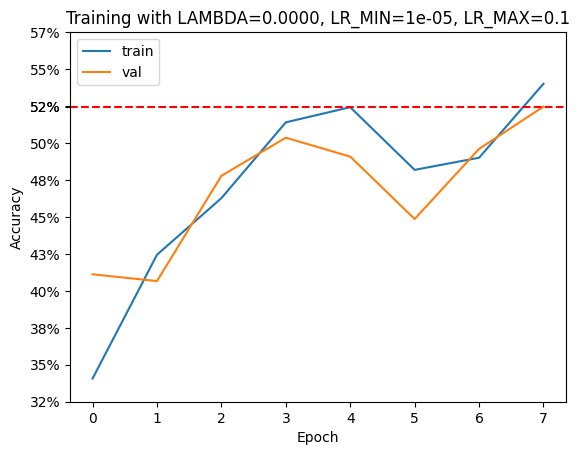

In [70]:
plt.plot(best_results["train_accs"], label="train")
plt.plot(best_results["val_accs"], label="val")

plt.axhline(max(best_results["val_accs"]), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(best_results["val_accs"])])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA:.4f}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


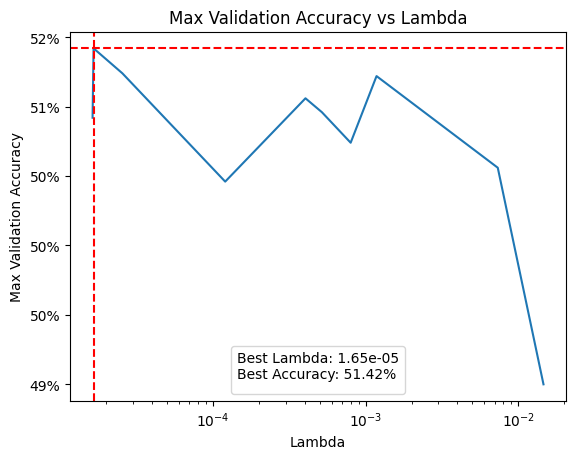

In [28]:
lambdas = sorted(results.keys())
max_val_accs = [max(results[l]["val_accs"]) for l in lambdas]

plt.plot(lambdas, max_val_accs)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
plt.axhline(max(best_results["val_accs"]), color="red", linestyle="--")
plt.axvline(best_lambda, color="red", linestyle="--")
plt.legend(
    title=f"Best Lambda: {best_lambda:.2e}\nBest Accuracy: {max(best_results['val_accs']):.2%}",
)


plt.xlabel("Lambda")
plt.ylabel("Max Validation Accuracy")
plt.title("Max Validation Accuracy vs Lambda")
plt.xscale("log")
plt.show()

## Let's repeat this process in the vicinity around the best LAMBDA value found above.

In [71]:
LAMBDA_MAX_POWER = -4.5
LAMBDA_MIN_POWER = -6.0
NUM_SAMPLES = 20
LAMBDAS = 10**(np.random.uniform(LAMBDA_MIN_POWER, LAMBDA_MAX_POWER, NUM_SAMPLES))


results = {}
for l in LAMBDAS:
    np.random.seed(400)
    model = MLP()
    optim = GD(model.parameters(), lr=ETA_MIN)
    sched = CyclicScheduler(optim, lr_start=ETA_MIN, lr_end=ETA_MAX, stepsize=NS)

    LAMBDA = l
    train_res, val_res, lrs = train(model, optim, sched, x_train, y_train, x_val, y_val)
    results[l] = {
        "train_losses": train_res[0], "train_costs": train_res[1], "train_accs": train_res[2],
        "val_losses": val_res[0], "val_costs": val_res[1], "val_accs": val_res[2],
        "lrs": lrs
    }

100%|██████████| 8/8 [01:07<00:00,  8.41s/it]


In [72]:
best_lambda, best_results = max(results.items(), key=lambda x: max(x[1]["val_accs"]))

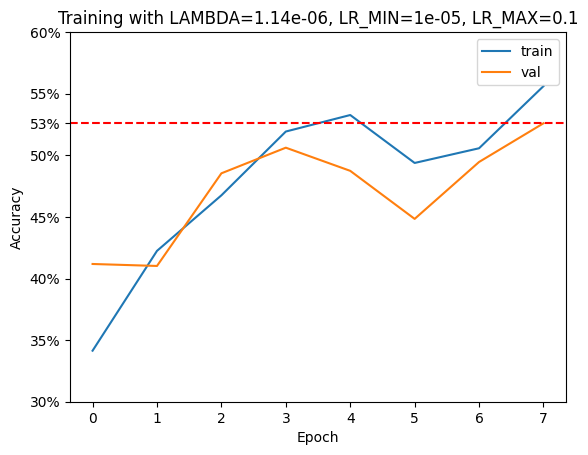

In [75]:
plt.plot(best_results["train_accs"], label="train")
plt.plot(best_results["val_accs"], label="val")

plt.axhline(max(best_results["val_accs"]), color="red", linestyle="--")
plt.yticks(list(plt.yticks()[0]) + [max(best_results["val_accs"])])
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

# normalized_lrs = (lrs - np.min(lrs)) / (np.max(lrs) - np.min(lrs)) * (np.max(train_accs) - np.min(train_accs)) + np.min(train_accs)
# plt.plot(normalized_lrs[::BATCH_SIZE], label="Learning Rate", color='gray', linestyle='--', alpha=0.5)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"Training with LAMBDA={LAMBDA:.2e}, LR_MIN={ETA_MIN}, LR_MAX={ETA_MAX}")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


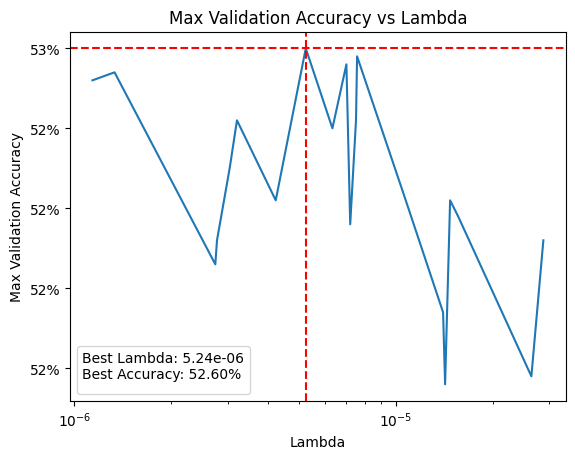

In [76]:
lambdas = sorted(results.keys())
max_val_accs = [max(results[l]["val_accs"]) for l in lambdas]

plt.plot(lambdas, max_val_accs)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
plt.axhline(max(best_results["val_accs"]), color="red", linestyle="--")
plt.axvline(best_lambda, color="red", linestyle="--")
plt.legend(
    title=f"Best Lambda: {best_lambda:.2e}\nBest Accuracy: {max(best_results['val_accs']):.2%}",
)


plt.xlabel("Lambda")
plt.ylabel("Max Validation Accuracy")
plt.title("Max Validation Accuracy vs Lambda")
plt.xscale("log")
plt.show()